In [169]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re

from IPython.display import display
from ipywidgets import widgets

In [2]:
json_file_names = !ls data/coreutils_coverage/

In [84]:
function_coverage_info = list()
for json_file_name in json_file_names:
    with open(f"data/coreutils_coverage/{json_file_name}", "r") as json_file:
        json_contents = json.load(json_file)
    for source_file in json_contents["files"]:
        for function in source_file["functions"]:
            info = {
                "executable_name": json_contents["data_file"],
                "source_file": source_file["file"],
                "function_name": function["name"],
                "basic_blocks": function["blocks"],
                "executed_basic_blocks": function["blocks_executed"],
                "basic_block_coverage": function["blocks_executed"] / function["blocks"] if function["blocks"] else None,
                "number_of_times_executed": function["execution_count"],
                "number_of_lines": function["end_line"] - function["start_line"]
            }
            function_coverage_info.append(info)

In [104]:
function_coverage_df = pd.DataFrame(function_coverage_info)
function_coverage_df = function_coverage_df[function_coverage_df.function_name != "main"]

In [105]:
function_coverage_df.head()

,executable_name,source_file,function_name,basic_blocks,executed_basic_blocks,basic_block_coverage,number_of_times_executed,number_of_lines
0,src/basename,/home/luiz/Desktop/coreutils/src/basename.c,usage,11,11,1.0,14,37
1,src/basename,/home/luiz/Desktop/coreutils/src/basename.c,remove_suffix,8,8,1.0,15,13
2,src/basename,/home/luiz/Desktop/coreutils/src/basename.c,perform_basename,11,11,1.0,49,17
4,src/basename,/home/luiz/Desktop/coreutils/src/system.h,initialize_exit_failure,3,0,0.0,0,4
5,src/basename,/home/luiz/Desktop/coreutils/src/system.h,to_uchar,2,0,0.0,0,0


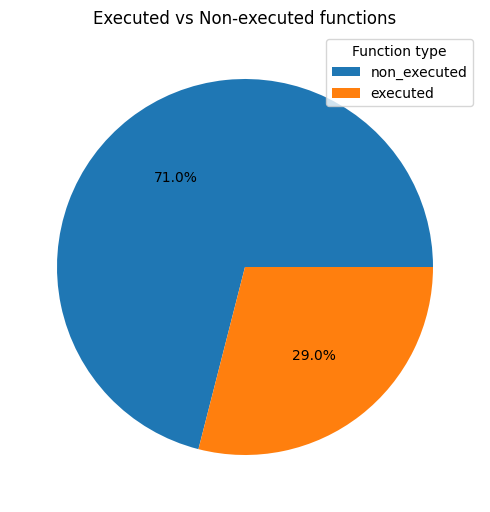

,type,number_of_functions
0,non_executed,3080
1,executed,1257


In [154]:
executed_vs_non_executed_counts = pd.DataFrame([
    {
        "type": "non_executed",
        "number_of_functions":  (function_coverage_df.number_of_times_executed == 0).sum()
    },
    {
        "type": "executed",
        "number_of_functions":  (function_coverage_df.number_of_times_executed > 0).sum()
    },
]
)

plt.figure(figsize=(5, 5))
plt.pie(executed_vs_non_executed_counts["number_of_functions"], autopct='%1.1f%%')
plt.legend(executed_vs_non_executed_counts["type"], title='Function type', loc='upper right')
plt.tight_layout()
plt.title("Executed vs Non-executed functions")
plt.show()

executed_vs_non_executed_counts

## Non-executed functions

In [107]:
non_executed_functions_df = function_coverage_df[function_coverage_df.number_of_times_executed == 0][["executable_name", "source_file", "function_name", "basic_blocks", "number_of_lines"]]
non_executed_functions_df.head()

,executable_name,source_file,function_name,basic_blocks,number_of_lines
4,src/basename,/home/luiz/Desktop/coreutils/src/system.h,initialize_exit_failure,3,4
5,src/basename,/home/luiz/Desktop/coreutils/src/system.h,to_uchar,2,0
6,src/basename,/home/luiz/Desktop/coreutils/src/system.h,select_plural,2,6
7,src/basename,/home/luiz/Desktop/coreutils/src/system.h,dot_or_dotdot,11,9
8,src/basename,/home/luiz/Desktop/coreutils/src/system.h,readdir_ignoring_dot_and_dotdot,7,8


In [108]:
non_executed_functions_df[["basic_blocks", "number_of_lines"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
basic_blocks,3080.0,4.921104,5.713861,1.0,2.0,2.0,6.0,135.0
number_of_lines,3080.0,10.348377,12.488477,0.0,4.0,7.0,11.0,372.0


In [109]:
number_of_non_executed_functions_per_file = (
    non_executed_functions_df.groupby("source_file").size().sort_values(ascending=False)
)
number_of_non_executed_functions_per_file

source_file
/home/luiz/Desktop/coreutils/src/system.h               2011
/home/luiz/Desktop/coreutils/lib/gettext.h               360
/usr/include/aarch64-linux-gnu/bits/byteswap.h           273
/usr/include/aarch64-linux-gnu/bits/uintn-identity.h     273
/home/luiz/Desktop/coreutils/src/ls.c                     68
/home/luiz/Desktop/coreutils/lib/smack.h                  10
/home/luiz/Desktop/coreutils/src/who.c                     9
/home/luiz/Desktop/coreutils/src/od.c                      7
/home/luiz/Desktop/coreutils/src/pwd.c                     6
/home/luiz/Desktop/coreutils/src/make-prime-list.c         5
/home/luiz/Desktop/coreutils/src/chcon.c                   4
/home/luiz/Desktop/coreutils/src/expr.c                    4
/home/luiz/Desktop/coreutils/src/sort.c                    4
/home/luiz/Desktop/coreutils/src/ptx.c                     4
/home/luiz/Desktop/coreutils/src/test.c                    3
/home/luiz/Desktop/coreutils/src/chroot.c                  3
/home/luiz/D

In [110]:
number_of_non_executed_functions_per_executable = (
    non_executed_functions_df.groupby("executable_name").size().sort_values(ascending=False)
)
number_of_non_executed_functions_per_executable

executable_name
src/ls                 98
src/who                43
src/pwd                40
src/chcon              37
src/pathchk            37
                       ..
src/split              30
src/truncate           30
src/cut                30
src/paste              30
src/make-prime-list    11
Length: 91, dtype: int64

## Executed functions

In [111]:
executed_functions_df = function_coverage_df[function_coverage_df.number_of_times_executed > 0]
executed_functions_df = executed_functions_df.sort_values(by=["number_of_times_executed", "basic_block_coverage"], ascending=False)
executed_functions_df.head()

,executable_name,source_file,function_name,basic_blocks,executed_basic_blocks,basic_block_coverage,number_of_times_executed,number_of_lines
3154,src/sort,/home/luiz/Desktop/coreutils/src/sort.c,compare,16,15,0.937500,2623599,39
3152,src/sort,/home/luiz/Desktop/coreutils/src/sort.c,diff_reversed,5,5,1.000000,2609248,3
339,src/csplit,/home/luiz/Desktop/coreutils/src/csplit.c,remove_line,15,15,1.000000,2501173,44
340,src/csplit,/home/luiz/Desktop/coreutils/src/csplit.c,find_line,18,17,0.944444,2501159,32
332,src/csplit,/home/luiz/Desktop/coreutils/src/csplit.c,keep_new_line,7,7,1.000000,2501147,22


In [155]:
executed_functions_df[["basic_blocks", "executed_basic_blocks", "basic_block_coverage", "number_of_times_executed", "number_of_lines"]].describe().transpose().drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
basic_blocks,18.237868,24.973934,1.000000,5.000000,11.0,20.0,290.0
executed_basic_blocks,14.372315,18.502017,1.000000,4.000000,9.0,17.0,243.0
basic_block_coverage,0.874540,0.180391,0.037037,0.833333,1.0,1.0,1.0
number_of_times_executed,37005.054097,238316.587568,1.000000,12.000000,60.0,885.0,2623599.0
number_of_lines,33.748608,48.107998,0.000000,6.000000,17.0,43.0,572.0


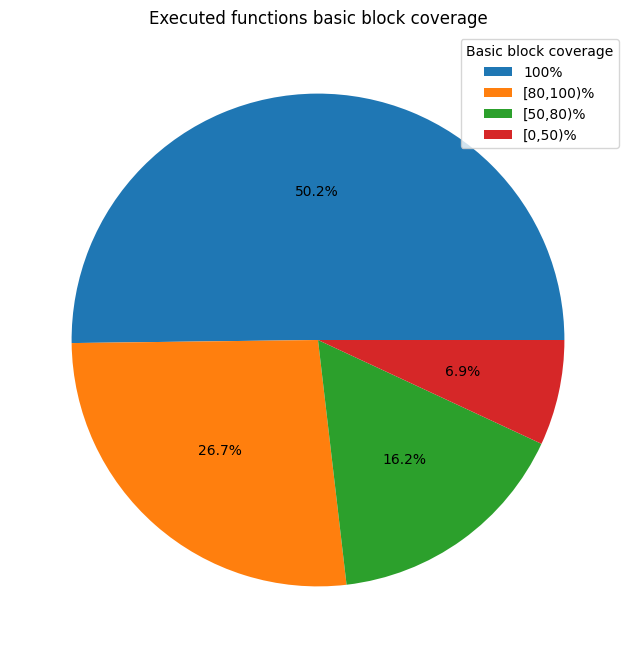

basic_block_coverage
100%         631
[80,100)%    335
[50,80)%     204
[0,50)%       87
Name: count, dtype: int64

In [158]:
bins = [0, 0.5, 0.8, 0.99, 1]

coverage_bins = (
    pd.cut(
        executed_functions_df["basic_block_coverage"], bins=bins, labels=["[0,50)%", "[50,80)%", "[80,100)%", "100%"]).value_counts()
)

plt.figure(figsize=(8, 8))
plt.pie(coverage_bins, autopct='%1.1f%%')

plt.legend(coverage_bins.index, title='Basic block coverage', loc='upper right')

plt.title("Executed functions basic block coverage")
plt.show()

coverage_bins.sort_values(ascending=False)

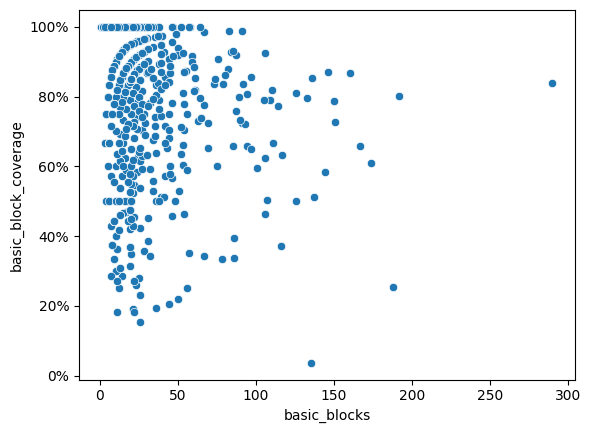

In [113]:
sns.scatterplot(data=executed_functions_df[["basic_blocks", "basic_block_coverage"]], x="basic_blocks", y="basic_block_coverage")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

<Axes: xlabel='number_of_lines', ylabel='basic_blocks'>

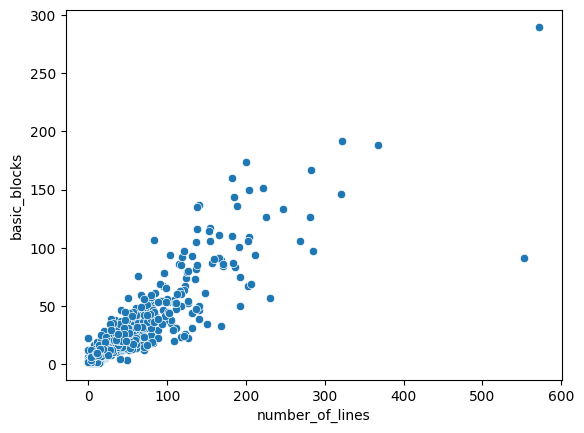

In [115]:
sns.scatterplot(data=executed_functions_df[["number_of_lines", "basic_blocks"]], x="number_of_lines", y="basic_blocks")

### Full-coverage functions

In [124]:
full_coverage_functions_df = executed_functions_df[executed_functions_df.basic_block_coverage == 1].drop(columns=["basic_block_coverage"])
full_coverage_functions_df.head()

,executable_name,source_file,function_name,basic_blocks,executed_basic_blocks,number_of_times_executed,number_of_lines
3152,src/sort,/home/luiz/Desktop/coreutils/src/sort.c,diff_reversed,5,5,2609248,3
339,src/csplit,/home/luiz/Desktop/coreutils/src/csplit.c,remove_line,15,15,2501173,44
332,src/csplit,/home/luiz/Desktop/coreutils/src/csplit.c,keep_new_line,7,7,2501147,22
3146,src/sort,/home/luiz/Desktop/coreutils/src/sort.c,key_numeric,7,7,2394482,3
983,src/factor,/home/luiz/Desktop/coreutils/src/factor.c,lbuf_putc,17,17,2340663,34


In [168]:
full_coverage_functions_df[["basic_blocks", "number_of_lines"]].describe().transpose().drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
basic_blocks,7.532488,7.801006,1.0,2.0,5.0,10.0,64.0
number_of_lines,16.619651,24.125095,0.0,4.0,7.0,18.0,231.0


### Functions that only have basic types

In [192]:
coreutils_function_types_data = {
    "function_name": list(),
    "argument_types": list(),
    "return_type": list()
}
pattern = r"(.*),args:\[(.*)\],ret:(.*)"

with open('data/coreutils_function_types.csv', 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        function_name = match.group(1)
        argument_types = match.group(2).split(";")[:-1]
        return_type = match.group(3)
        coreutils_function_types_data["function_name"].append(function_name)
        coreutils_function_types_data["argument_types"].append(argument_types)
        coreutils_function_types_data["return_type"].append(return_type)

In [196]:
non_primitive_function_names = set()
primitive_numerical_types = {"i1", "i8", "i16", "i32", "i64"}
for function_name, argument_types, return_type in zip(coreutils_function_types_data["function_name"], coreutils_function_types_data["argument_types"], coreutils_function_types_data["return_type"]):
    non_primitive_arguments = not set(argument_types).issubset(primitive_numerical_types)
    non_primitive_return_type = return_type not in primitive_numerical_types
    if non_primitive_arguments or non_primitive_return_type:
        non_primitive_function_names.add(function_name)
fully_primitive_function_names = set(coreutils_function_types_data["function_name"]) - non_primitive_function_names
print("Number of fully primitive functions:", len(fully_primitive_function_names))

Number of fully primitive functions: 273


In [201]:
executed_primitive_functions_df = executed_functions_df[executed_functions_df.function_name.isin(fully_primitive_function_names)]
executed_primitive_functions_df.head()

,executable_name,source_file,function_name,basic_blocks,executed_basic_blocks,basic_block_coverage,number_of_times_executed,number_of_lines
3152,src/sort,/home/luiz/Desktop/coreutils/src/sort.c,diff_reversed,5,5,1.000000,2609248,3
3194,src/sort,/home/luiz/Desktop/coreutils/src/system.h,to_uchar,2,2,1.000000,1131513,0
2490,src/pr,/home/luiz/Desktop/coreutils/src/pr.c,char_to_clump,35,26,0.742857,864005,92
3826,src/tr,/home/luiz/Desktop/coreutils/src/system.h,to_uchar,2,2,1.000000,824503,0
3228,src/split,/home/luiz/Desktop/coreutils/src/split.c,ignorable,6,6,1.000000,605310,3


In [207]:
executed_primitive_functions_df[["basic_blocks", "basic_block_coverage", "number_of_lines"]].describe().transpose().drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
basic_blocks,14.086614,25.072284,2.000000,2.000000,7.0,13.0,167.0
basic_block_coverage,0.896676,0.175807,0.037037,0.845238,1.0,1.0,1.0
number_of_lines,20.551181,35.922471,0.000000,3.000000,7.0,22.5,282.0


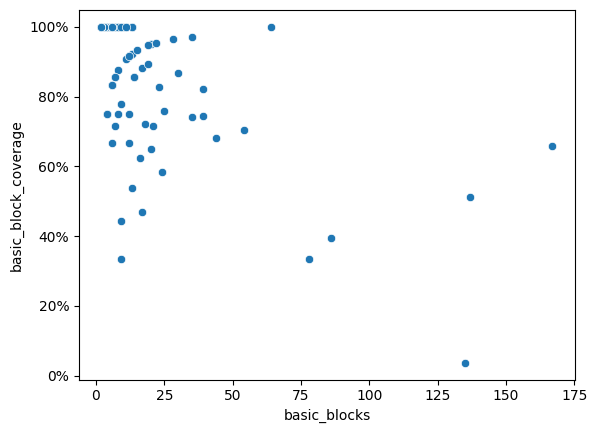

In [209]:
sns.scatterplot(data=executed_primitive_functions_df[["basic_blocks", "basic_block_coverage"]], x="basic_blocks", y="basic_block_coverage")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))